### TAHMO Data

In [1]:
!pip install filter_stations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 646.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 6.0 MB/s eta 0:00:00


In [61]:
import ee
import pandas as pd
from filter_stations import retreive_data
import json
import os
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar

In [2]:
# upload config file
from google.colab import files
uploaded = files.upload()

Saving config.json to config.json


### ToDo: Steps to setting up Google Earth Engine Project

In [7]:
config_path = '/content/config.json'

with open(config_path) as f:
    config = json.load(f)

ee.Authenticate()

# Initialize Google Earth Engine
ee.Initialize(project='ee-kaburiaaustin1')

# authenticate the api
api_key = config['apiKey']
api_secret = config['apiSecret']
maps_key = config['map_api_key']

ret = retreive_data(api_key, api_secret, maps_key)

# Window for the experiments
start_date='2023-01-01'
end_date='2023-12-31'



### TAHMO Quality flags

In [54]:
# get the quality flags for the stations
variables = ['pr']
dataset = 'controlled'
aggregate = '1d'
csv_file_name = f'KE-2023-01-01-2023-12-31'
quality_flags = True

ke_stations = list(ret.get_stations_info(countrycode='KE').code)

mult = ret.multiple_measurements(
    stations_list=ke_stations,
    startDate=start_date,
    endDate=end_date,
    variables=variables,
    dataset=dataset,
    aggregate=aggregate,
    csv_file=csv_file_name,
    quality_flags=True
)

# Define the function to get the stations without flags 3 and 4
def q_flag_stations(df, start_date, end_date):
    """
    This function takes a dataframe, start date, and end date and returns the stations that have flags 3 and 4.
    """
    Q_FLAG = df.filter(like='Q_FLAG').columns
    non_na = df[Q_FLAG].loc[start_date: end_date].dropna(axis=1)
    flag_3 = non_na.columns[non_na.isin([3, 3.0]).any()]
    flag_4 = non_na.columns[non_na.isin([4, 4.0]).any()]
    flag_3_4 = set(flag_3).union(set(flag_4))
    return non_na.drop(columns=flag_3_4).columns

# get the stations without flags 3 and 4
def subset_stations(q_flags_df, start_date, end_date):
    """
    This function takes the multiple measurements dataframe, start date, and end date and returns the stations without flags 3 and 4.
    """
    stations = q_flag_stations(q_flags_df, start_date, end_date)
    # remove _Q_FLAG in the station names
    stations = [station.replace('_Q_FLAG', '') for station in stations]
    return stations

def handle_multiple_sensors(df):
    """
    This function takes a DataFrame and returns the stations without multiple sensors.
    If a station has multiple sensors, it returns the one with the highest amount of data.
    """
    # Create a set to store stations that have already been processed
    processed_stations = set()
    interest_cols = []

    # Loop through columns in the dataframe
    for col in df.columns:
        # Split by underscore to identify station and sensor
        station = col.split('_')[0]

        # Check if the station has already been processed
        if station not in processed_stations:
            # Get all columns for the current station
            station_cols = [i for i in df.columns if i.startswith(station)]

            if len(station_cols) > 1:
                # If there are multiple sensors for the station, choose the one with the highest data count
                sensor_col = max(station_cols, key=lambda x: df[x].count())
                interest_cols.append(sensor_col)
            else:
                # If only one sensor exists, just take that column
                interest_cols.append(station_cols[0])

            # Mark the station as processed
            processed_stations.add(station)
        else:
            continue

    # Subset the DataFrame to only the columns of interest
    df = df[interest_cols]

    # Rename the columns to just the station name (remove sensor info)
    df.columns = [i.split('_')[0] for i in df.columns]

    return df


Retrieving data for stations:   0%|          | 0/176 [00:00<?, ?it/s]

Split observations for pr per sensor
Split observations for pr per sensor
Split observations for pr per sensor
Split observations for pr per sensor
Split observations for pr per sensor
Split observations for pr per sensor


In [ ]:
interest_stations = subset_stations(mult, start_date, end_date)


In [49]:
variables = ['pr']
dataset = 'controlled'
csv_file_name = f'pr-2023'

# Aggregate presipitation data for 1 day the current default is summming up
pr_df = ret.multiple_measurements(
    startDate=start_date, endDate=end_date,
    dataset=dataset, stations_list=interest_stations,
    csv_file=csv_file_name, aggregate='1D',
    variables=variables
)

# Getting temperature data for the same duration 5min interval
variables = ['te']
csv_file_name = f'te-2023-2024'
te_df = ret.multiple_measurements(
    startDate=start_date, endDate=end_date,
    dataset=dataset, stations_list=stations,
    csv_file=csv_file_name, aggregate='5min',
    variables=variables
)

# Aggregate the te_df per day by mean
print('Aggregating temperature data ---')
te_df_agg = ret.aggregate_variables(te_df, freq='1D', method='mean')

# Get the stations metadata
print('Getting stations metadata ---')
stations_metadata = ret.get_stations_info(multipleStations=interest_stations)

# Get the stations info for kenya
print('Getting stations metadata for kenya ---')
stations_ke = ret.get_stations_info(countrycode='KE')

# Get the available variables
print('Getting available variables ---')
we_vars = ret.get_variables()

In [3]:

# Sample stations list
stations = [
    'TA00026',
    'TA00028',
    'TA00029',
    'TA00056',
    'TA00073',
    'TA00074',
    'TA00078',
    'TA00166',
    'TA00172',
    'TA00174',
    'TA00190',
    'TA00196',
    'TA00247',
    'TA00283', # Dedan Kimathi station
    'TA00377',
    'TA00379',
    'TA00386',
    'TA00414',
    'TA00416',
    'TA00444',
    'TA00719'
]

if __name__ == '__main__':
    variables = ['pr']
    start_date = '2023-01-01'
    end_date = '2023-12-31'
    dataset = 'controlled'
    csv_file_name = f'pr-2023-2024'

  # Aggregate presipitation data for 1 day the current default is summming up
    pr_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='1D',
        variables=variables
    )

    # Getting temperature data for the same duration 5min interval
    variables = ['te']
    csv_file_name = f'te-2023-2024'
    te_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='5min',
        variables=variables
    )

    # Aggregate the te_df per day by mean
    print('Aggregating temperature data ---')
    te_df_agg = ret.aggregate_variables(te_df, freq='1D', method='mean')

    # Get the stations metadata
    print('Getting stations metadata ---')
    stations_metadata = ret.get_stations_info(multipleStations=stations)

    # Get the stations info for kenya
    print('Getting stations metadata for kenya ---')
    stations_ke = ret.get_stations_info(countrycode='KE')

    # Get the available variables
    print('Getting available variables ---')
    we_vars = ret.get_variables()



Retrieving data for stations:   0%|          | 0/24 [00:00<?, ?it/s]

Retrieving data for stations:   0%|          | 0/24 [00:00<?, ?it/s]

Aggregating temperature data ---
Getting stations metadata ---
Getting stations metadata for kenya ---
Getting available variables ---


In [103]:
stations_metadata

,code,status,installationdate,elevationground,sensorinstallations,dataloggerinstallations,creatorid,created,updaterid,updated,...,location.countrycode,location.zipcode,location.latitude,location.longitude,location.elevationmsl,location.note,location.creatorid,location.created,location.updaterid,location.updated
24,TA00026,1,2015-08-28T00:00:00Z,3.0,None,None,2,2018-12-11T08:15:40.289703Z,2,2018-12-11T08:15:40.289703Z,...,KE,,-0.287122,36.169981,1939.9,{},2,2018-10-26T13:27:43.87694Z,2,2022-07-26T07:25:44.100506Z
25,TA00027,0,2015-08-31T00:00:00Z,2.0,None,None,2,2018-12-11T08:33:13.846345Z,37,2019-03-22T08:43:27.216443Z,...,KE,,0.063061,37.656303,1607.0,{},2,2018-10-26T13:30:50.270697Z,2,2018-10-26T13:30:50.270697Z
26,TA00028,1,2015-08-31T00:00:00Z,9.0,None,None,2,2018-12-11T08:35:17.888233Z,2,2018-12-11T08:35:17.888233Z,...,KE,,0.055219,37.136747,2003.6,{},2,2018-10-26T13:32:16.15537Z,37,2022-06-30T11:11:50.27135Z
27,TA00029,1,2015-09-02T00:00:00Z,2.0,None,None,2,2018-12-11T08:36:19.30342Z,2,2018-12-11T08:36:19.30342Z,...,KE,,-0.500776,36.587511,2545.8,{},2,2018-10-26T13:33:31.451613Z,37,2022-02-28T12:25:09.578242Z
52,TA00056,1,2015-10-03T00:00:00Z,2.0,None,None,2,2018-12-11T09:20:32.851033Z,2,2018-12-11T09:20:32.851033Z,...,KE,,-0.721656,37.145585,1376.0,{},2,2018-10-29T09:11:21.843353Z,2,2018-10-29T09:11:21.843353Z
67,TA00073,1,2015-11-19T00:00:00Z,2.0,None,None,2,2018-12-11T09:37:47.276024Z,2,2018-12-11T09:37:47.276024Z,...,KE,,-0.071723,36.933835,1853.5,{},2,2018-10-29T10:24:02.405958Z,37,2022-02-28T12:46:24.127554Z
68,TA00074,1,2015-11-19T00:00:00Z,2.0,None,None,2,2018-12-11T09:38:25.742397Z,2,2018-12-11T09:38:25.742397Z,...,KE,,-0.566080,37.074412,1726.8,{},2,2018-10-29T10:35:28.49617Z,2,2022-07-26T07:38:42.100985Z
72,TA00078,1,2016-01-11T00:00:00Z,2.5,None,None,2,2018-12-11T09:41:34.473889Z,2,2018-12-11T09:41:34.473889Z,...,KE,,-0.200178,36.376936,2427.2,{},2,2018-10-29T10:49:20.072927Z,2,2022-07-26T07:39:36.348657Z
150,TA00166,1,2017-05-11T00:00:00Z,2.0,None,None,2,2018-12-12T08:29:28.10697Z,2,2018-12-12T08:29:28.10697Z,...,KE,,-0.319508,37.659139,1404.0,{},2,2018-11-10T08:47:37.949135Z,2,2018-11-10T08:47:37.949135Z
156,TA00172,1,2017-05-19T00:00:00Z,2.0,None,None,2,2018-12-12T08:55:49.278399Z,2,2018-12-12T08:55:49.278399Z,...,KE,,0.353931,37.587740,1110.0,{},2,2018-11-10T09:09:21.659661Z,2,2018-11-10T09:09:21.659661Z


### CHIRPS
Daily precipitation values

In [34]:
# Method to extract rainfall data at a specific point for each date in the time range
def extract_rainfall_series(lat, lon, start_date, end_date, range_roi=[36.0, -1.0, 37.0, 1.0]):
    '''
    lat - latitude
    lon - longitude
    start_date - start date in format 'YYYY-MM-DD'
    end_date - end date in format 'YYYY-MM-DD'
    range_roi - range of roi to extract rainfall data (The bounding box)
    '''

    # Define a region of interest (bounding box)
    roi = ee.Geometry.Rectangle(range_roi)  # Coordinates for an example region in Kenya
    # Add one day to the last day
    end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    # Load CHIRPS dataset
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
                .filterDate(f'{start_date}', f'{end_date}') \
                .filterBounds(roi)
    point = ee.Geometry.Point(lon, lat)  # Define the point from latitude and longitude

    # Map function to extract rainfall for each day and create a time series
    def extract_rainfall(image):
        # Get the date for the image (e.g., "YYYY-MM-DD")
        date = image.get('system:time_start')
        # Extract the rainfall value at the point for that date
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('precipitation')  # 'precipitation' is the band name for CHIRPS

        return ee.Feature(None, {
            'date': ee.Date(date).format('YYYY-MM-dd'),
            'rainfall': value
        })

    # Apply the function to each image in the collection
    rainfall_series = chirps.map(extract_rainfall)

    # Convert the FeatureCollection to a list of features
    features = rainfall_series.getInfo()['features']

    # Convert to pandas DataFrame
    data = [{'Date': f['properties']['date'], 'rainfall': f['properties']['rainfall']} for f in features]
    df = pd.DataFrame(data)

    # Ensure 'date' is a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    return df

# Example: Extract rainfall data for a specific point (latitude, longitude)
lat, lon = -0.287122, 36.169981  # Example coordinates
rainfall_df = extract_rainfall_series(lat, lon, start_date='2023-01-01', end_date='2023-12-31')


# Print the DataFrame containing the rainfall time series
rainfall_df


,Date,rainfall
0,2023-01-01,0.00000
1,2023-01-02,0.00000
2,2023-01-03,0.00000
3,2023-01-04,0.00000
4,2023-01-05,0.00000
...,...,...
360,2023-12-27,0.00000
361,2023-12-28,0.00000
362,2023-12-29,0.00000
363,2023-12-30,0.00000


In [35]:
# given the station name to get the coordinates (lat,lon)
def get_station_coords(station_name, metadata=stations_metadata):
  lat, lon = stations_metadata[stations_metadata['code'] == station_name][['location.latitude',
                                                                           'location.longitude']].values[0]
  return lat, lon

print(get_station_coords('TA00026'))

# rename the columns from chirps with the station name during extraction as the station name
def extract_with_station_name(station_name, start_date, end_date, metadata=stations_metadata,
                              range_roi=[36.0, -1.0, 37.0, 1.0], data='CHIRPS'):
  '''
  data - CHIRPS or ERA5
  '''
  # extract the data
  df = extract_rainfall_series(lat=get_station_coords(station_name, metadata=metadata)[0],
                               lon=get_station_coords(station_name, metadata=metadata)[1],
                               start_date=start_date, end_date=end_date,
                               range_roi=range_roi)
  # Rename the rainfall column to station_name
  df.rename(columns={'rainfall': station_name}, inplace=True)
  # set the Date as the index
  df.set_index('Date', inplace=True)
  return df

# Create one dataframe from the tahmo stations
station_name_list = stations_metadata['code'].tolist()

def create_df_from_stations(station_name_list, start_date, end_date, metadata=stations_metadata, range_roi=[36.0, -1.0, 37.0, 1.0]):
  df_list = []
  for station_name in station_name_list:
    df_list.append(extract_with_station_name(station_name, start_date, end_date, metadata=metadata, range_roi=range_roi))
  return pd.concat(df_list, axis=1)

chirps_tahmo_ke = create_df_from_stations(station_name_list, start_date='2023-01-01', end_date='2023-12-31')



(-0.2871222, 36.1699806)


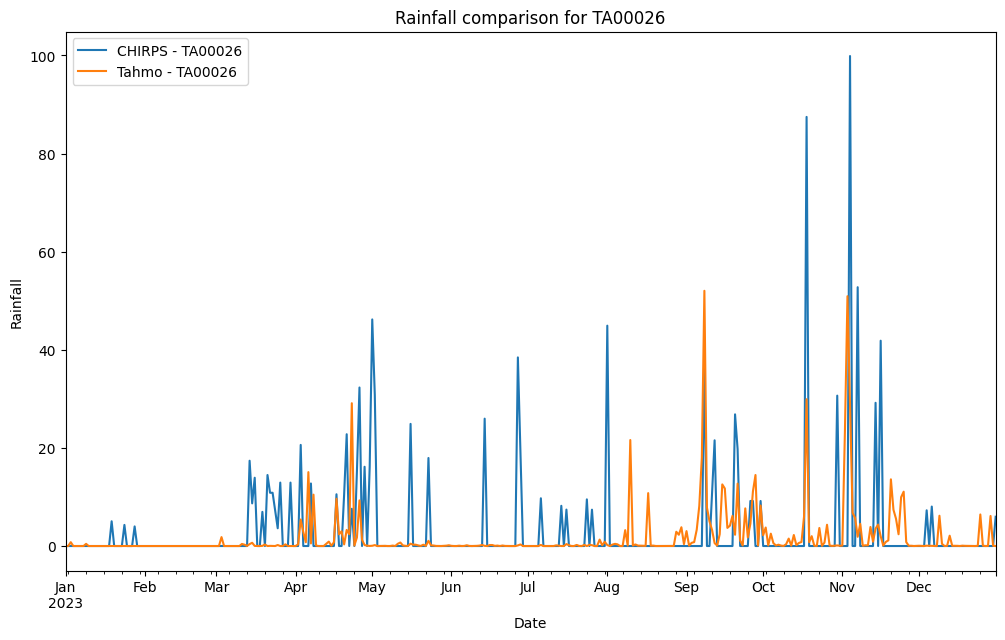

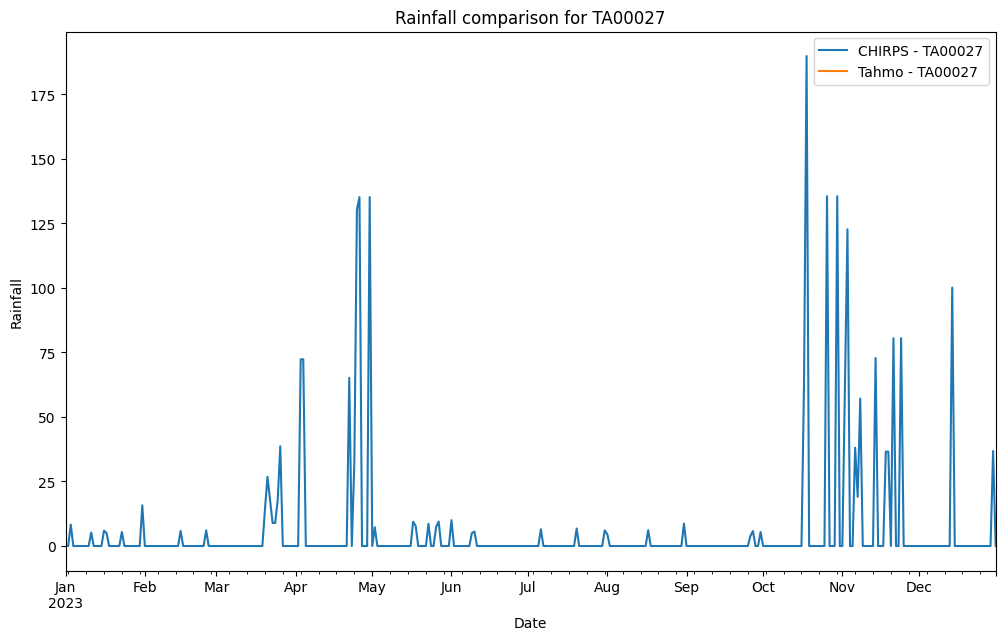

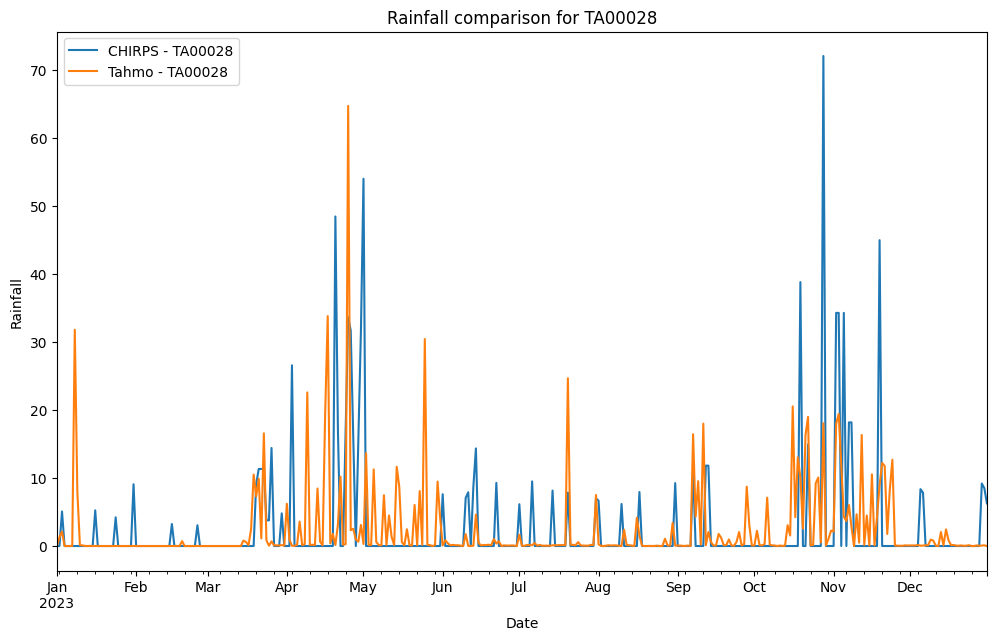

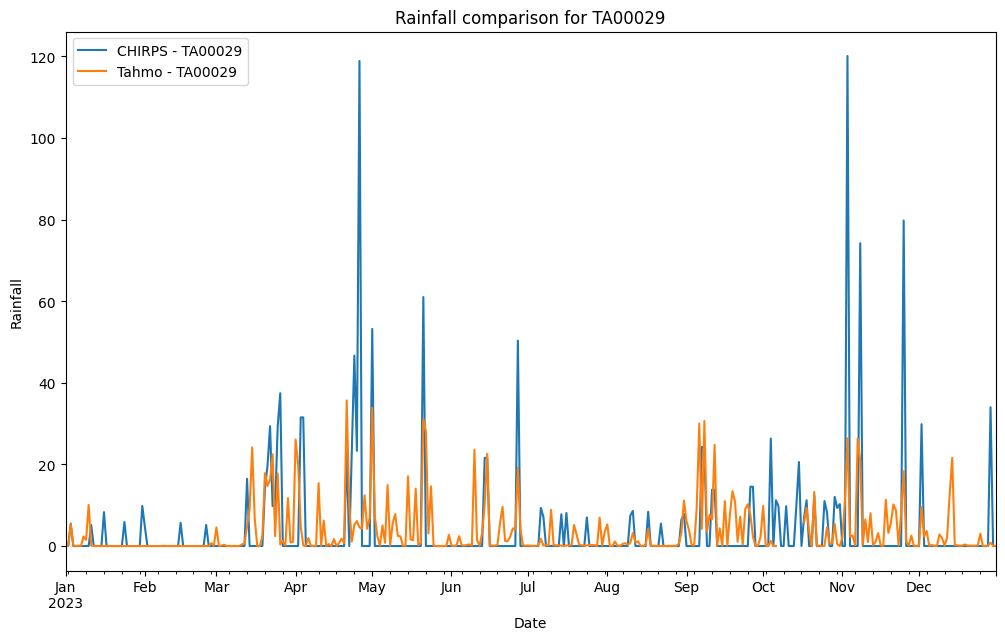

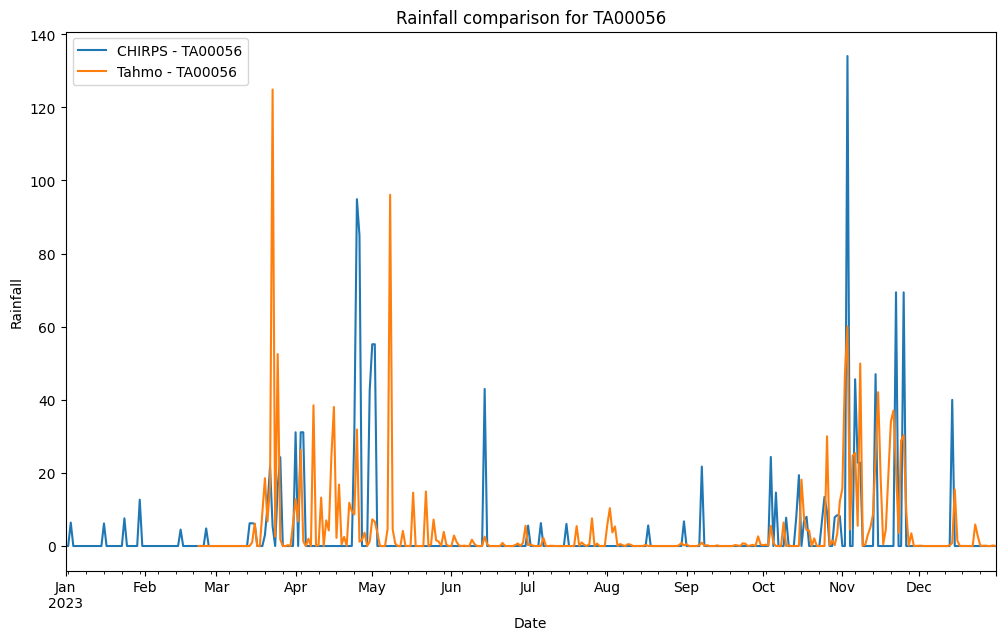

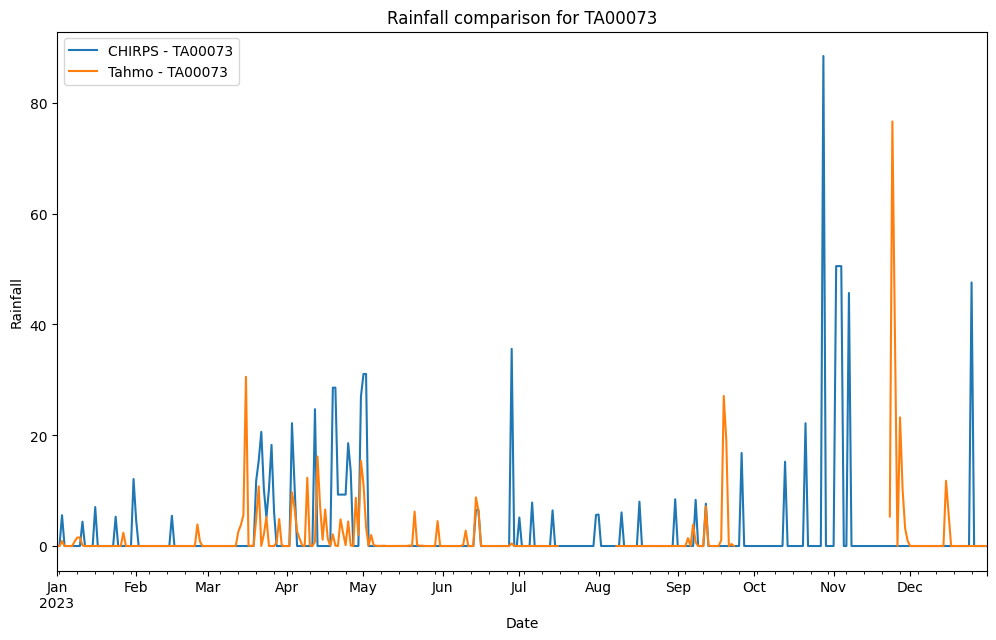

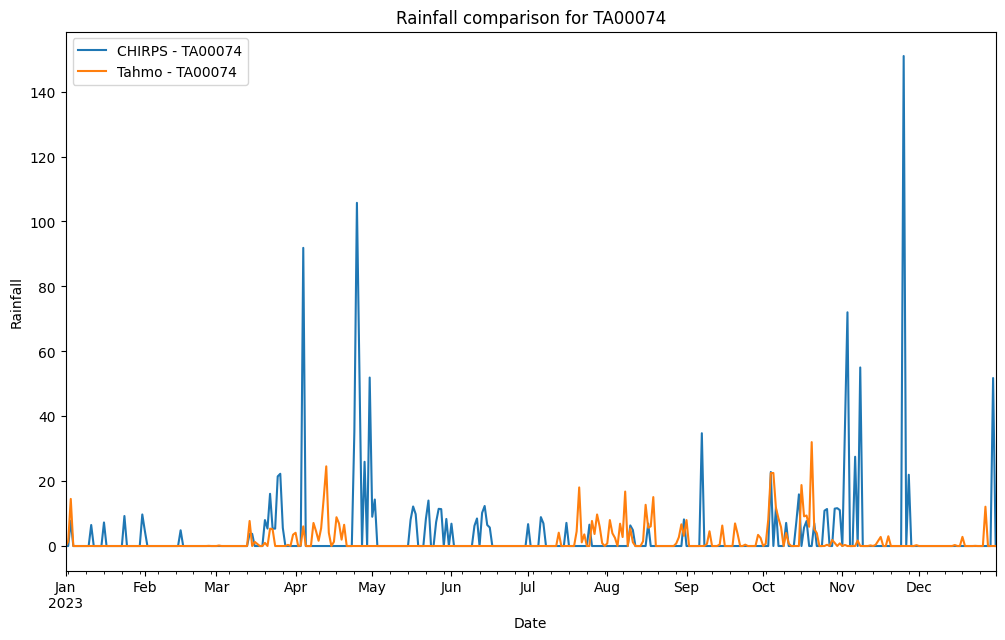

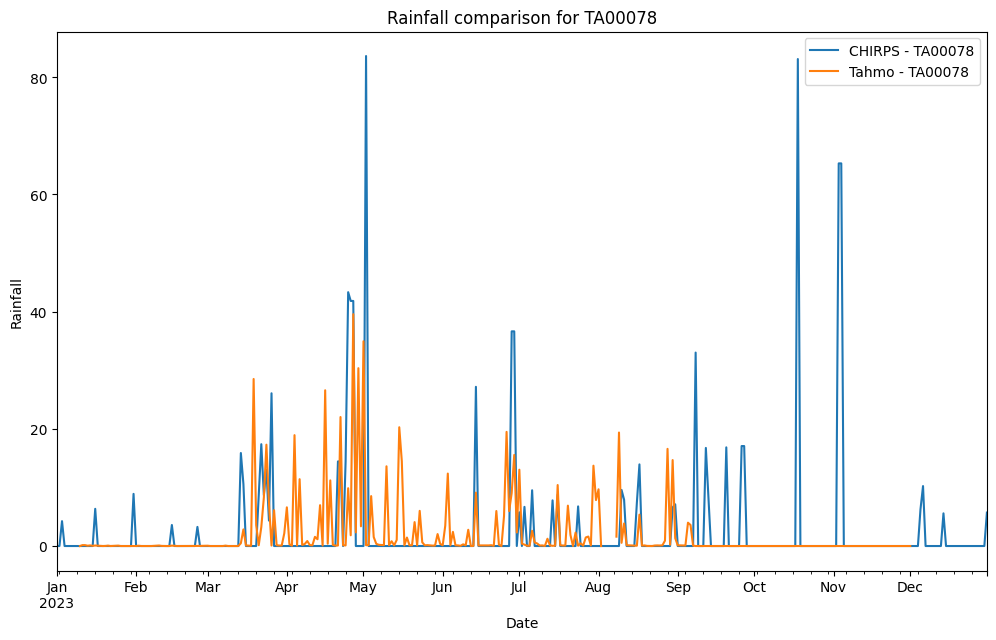

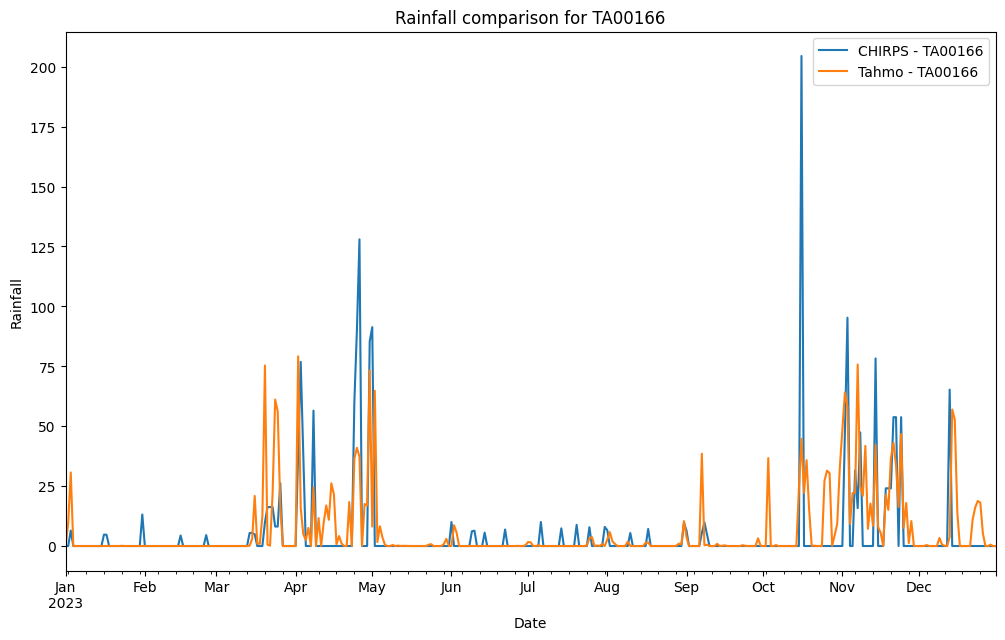

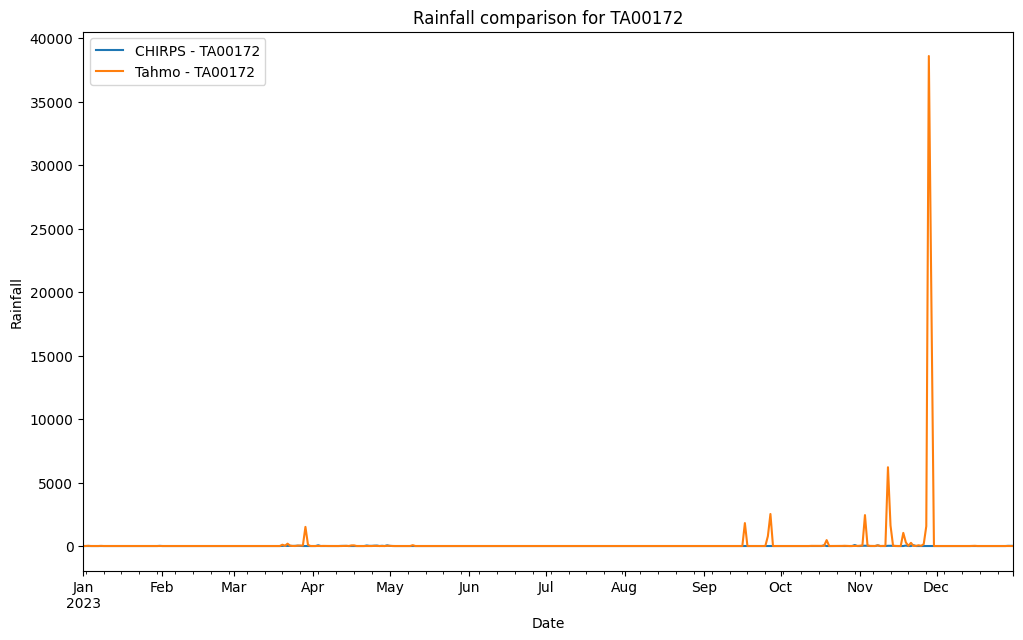

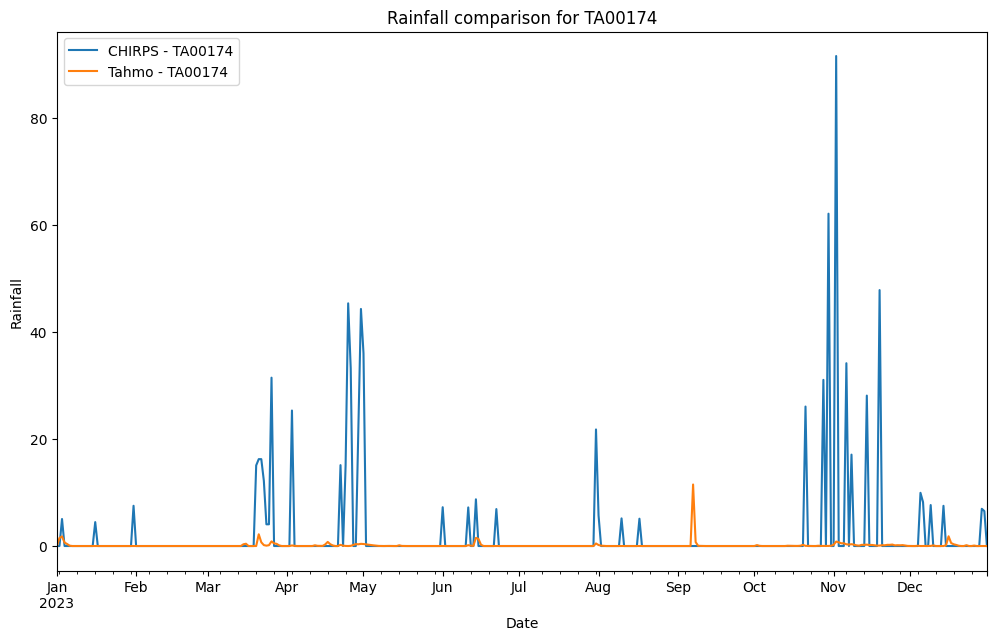

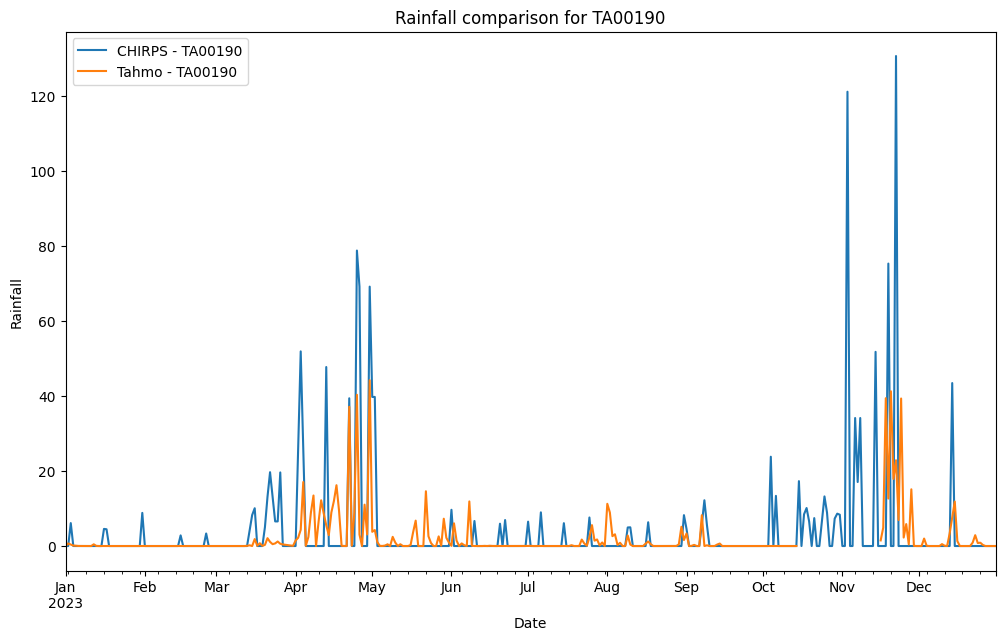

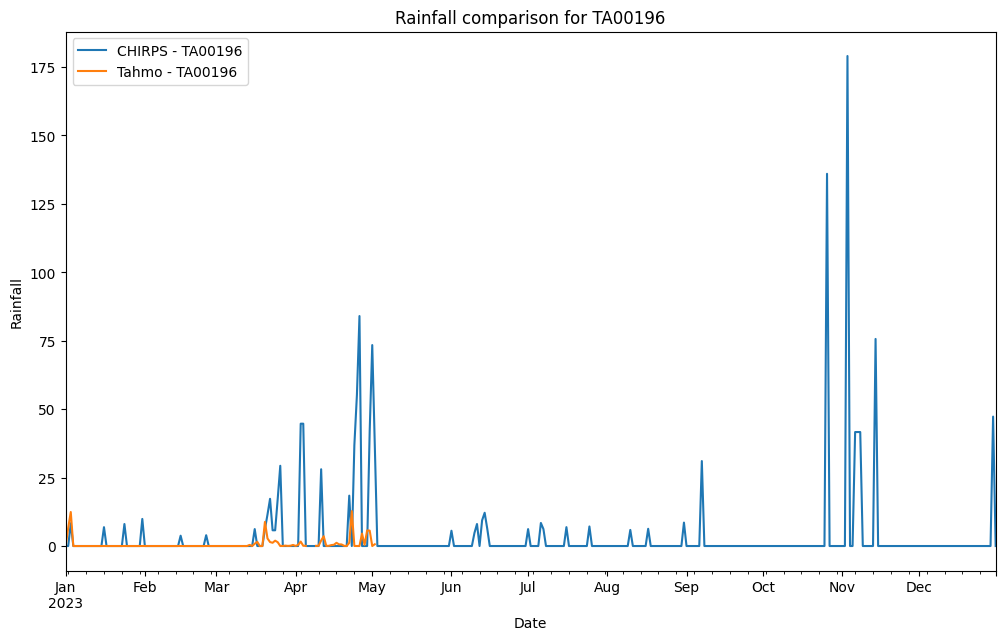

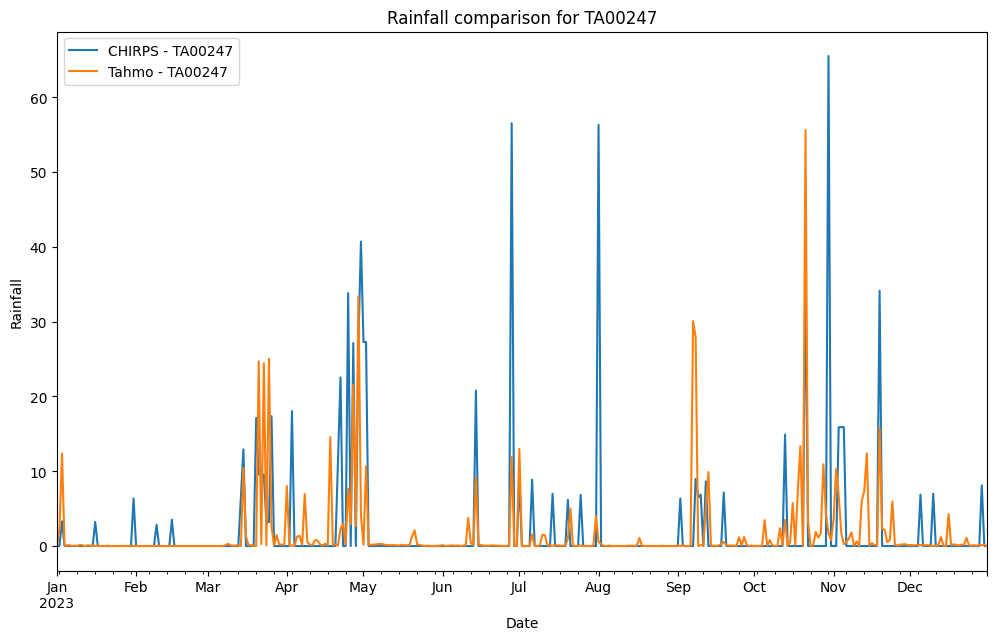

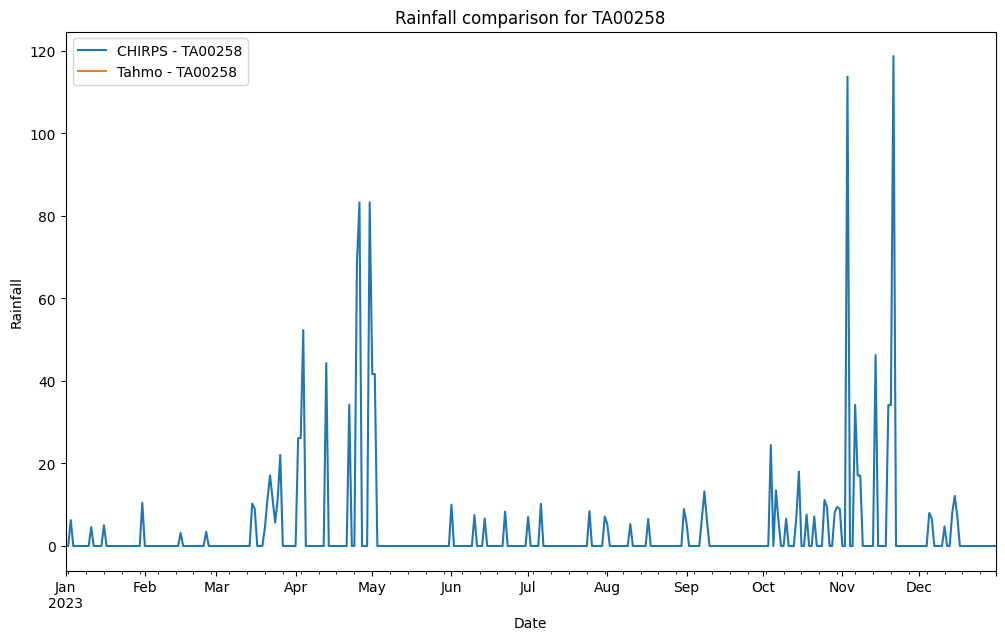

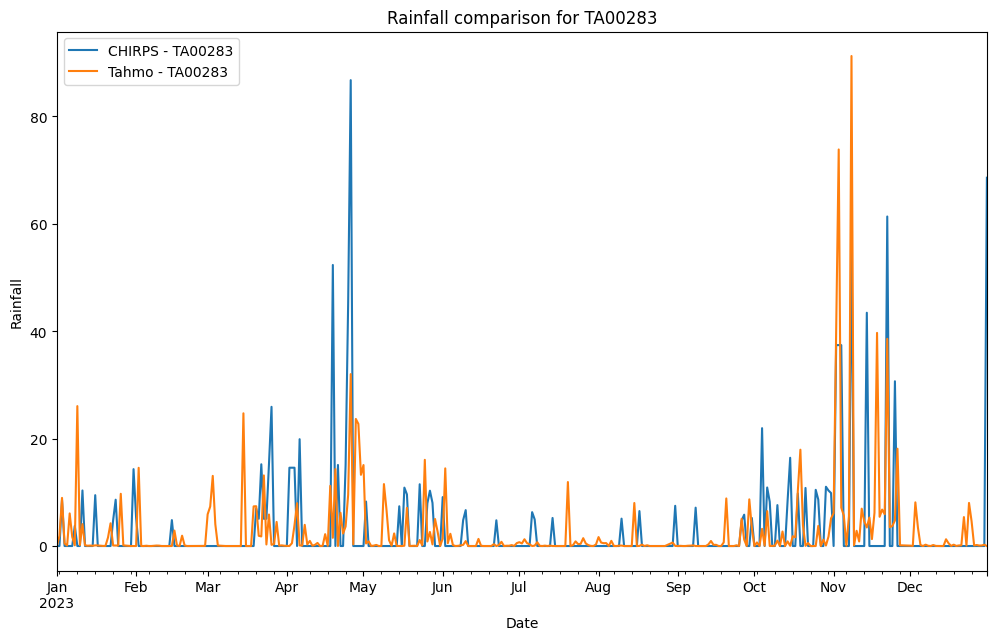

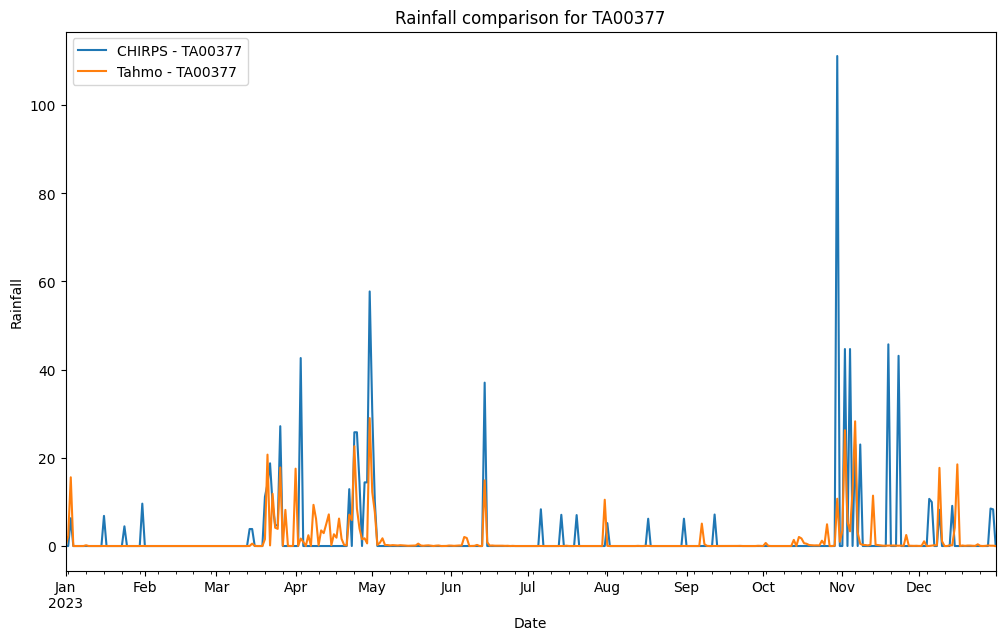

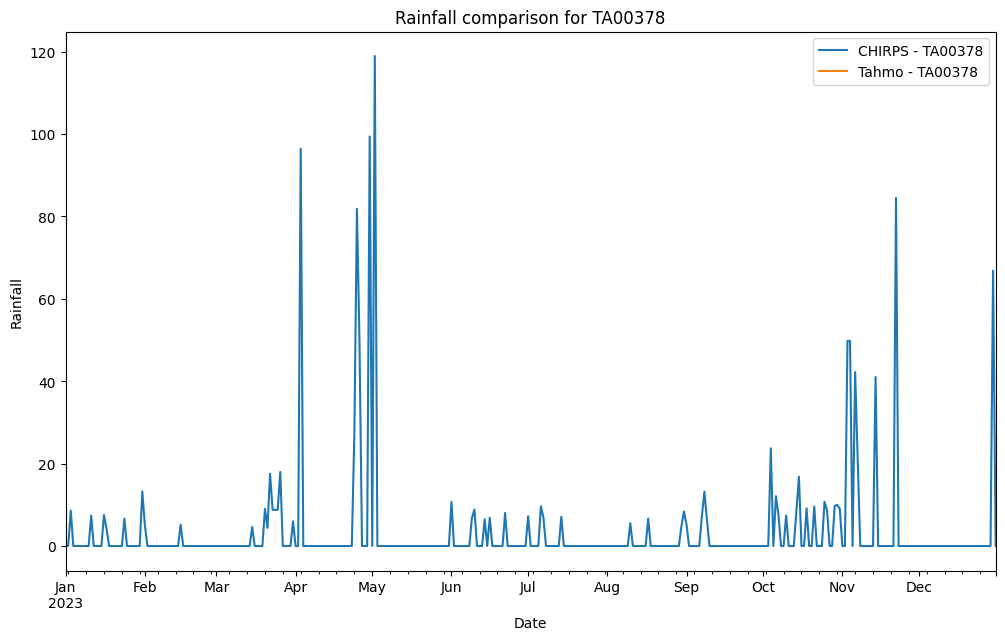

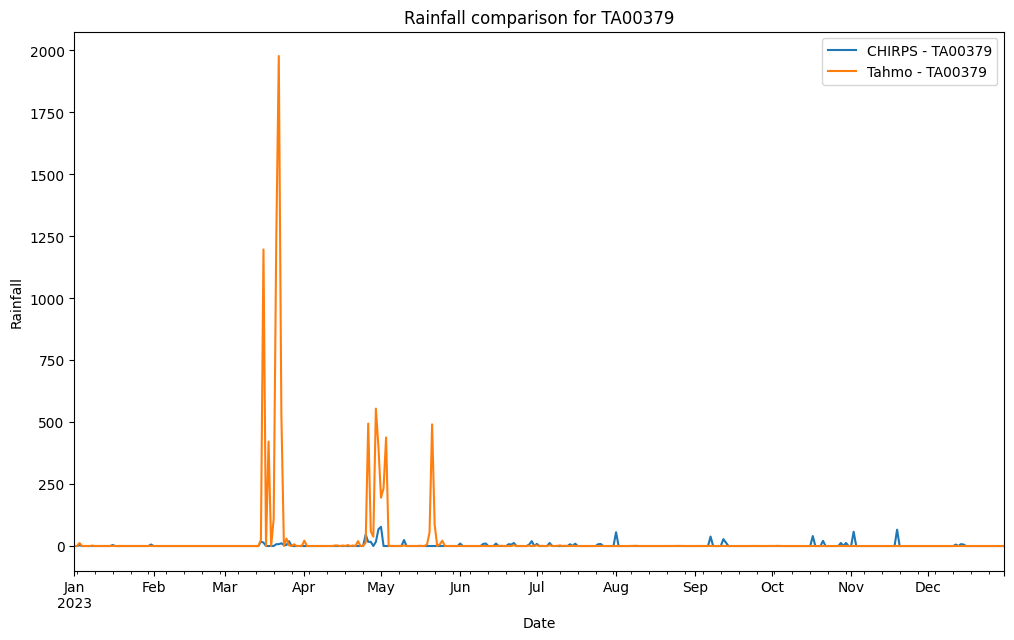

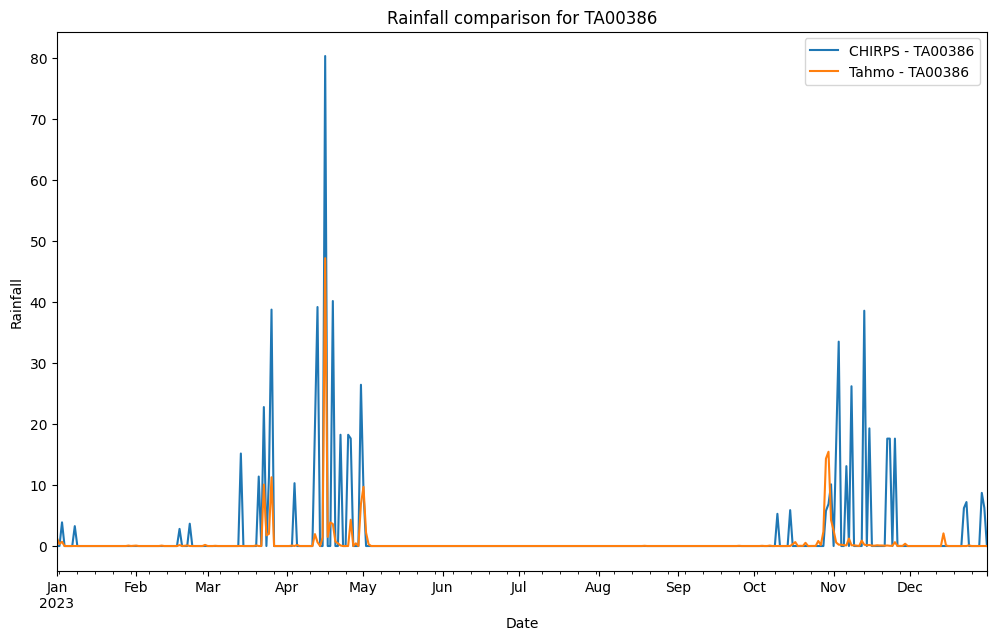

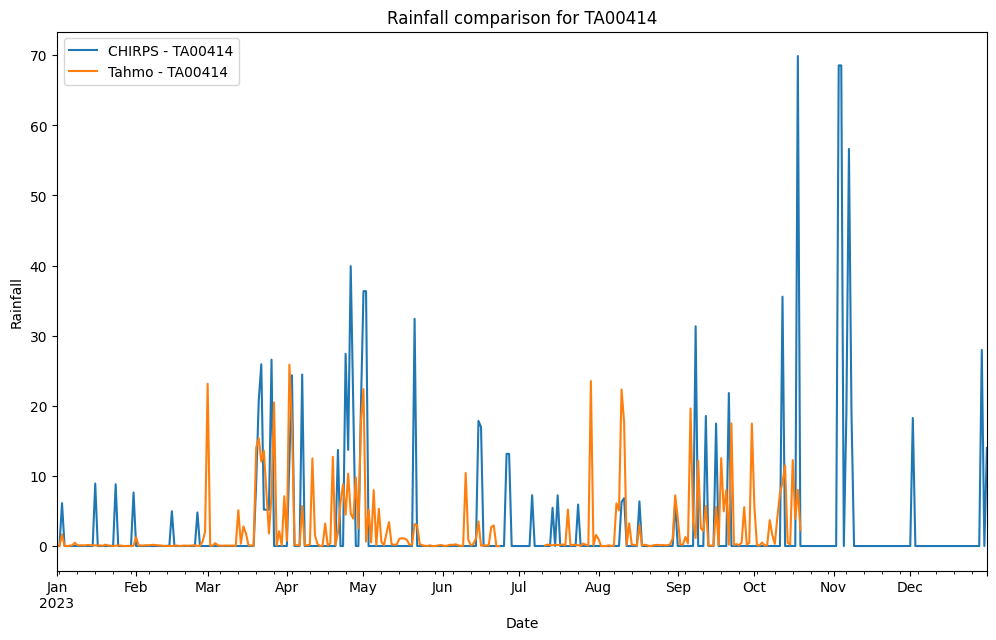

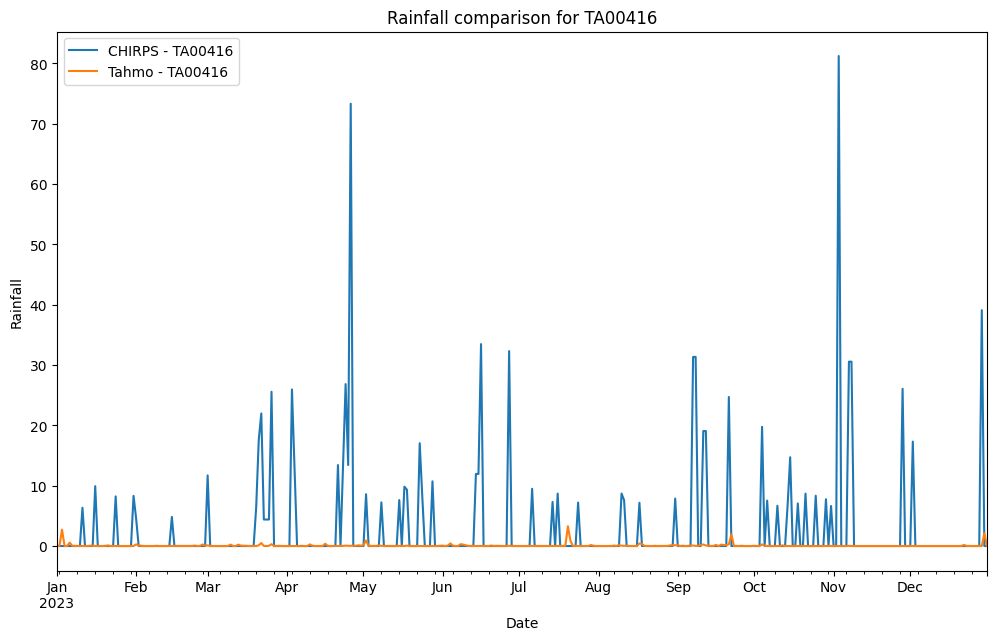

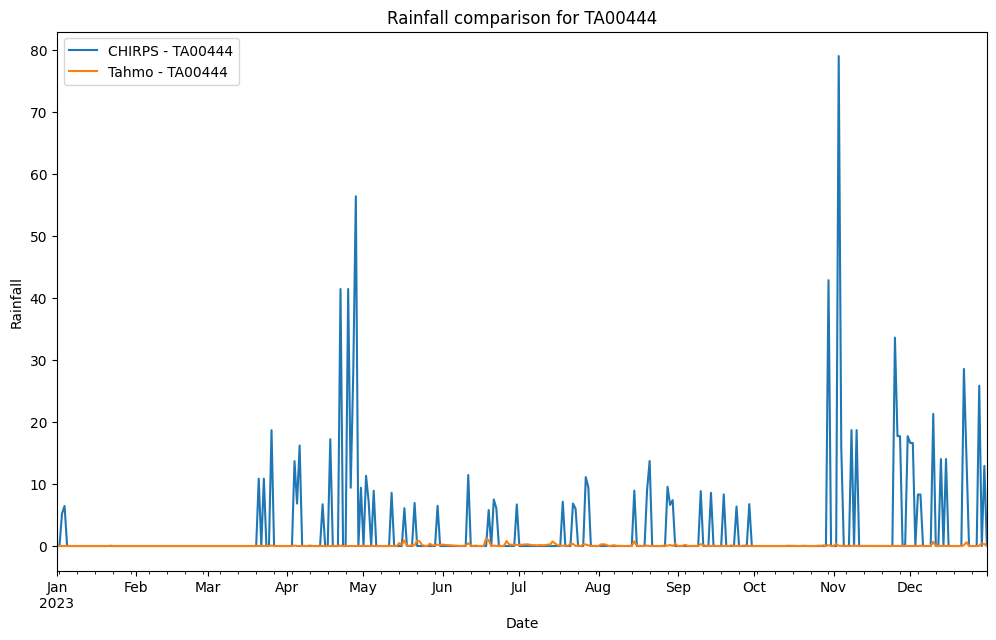

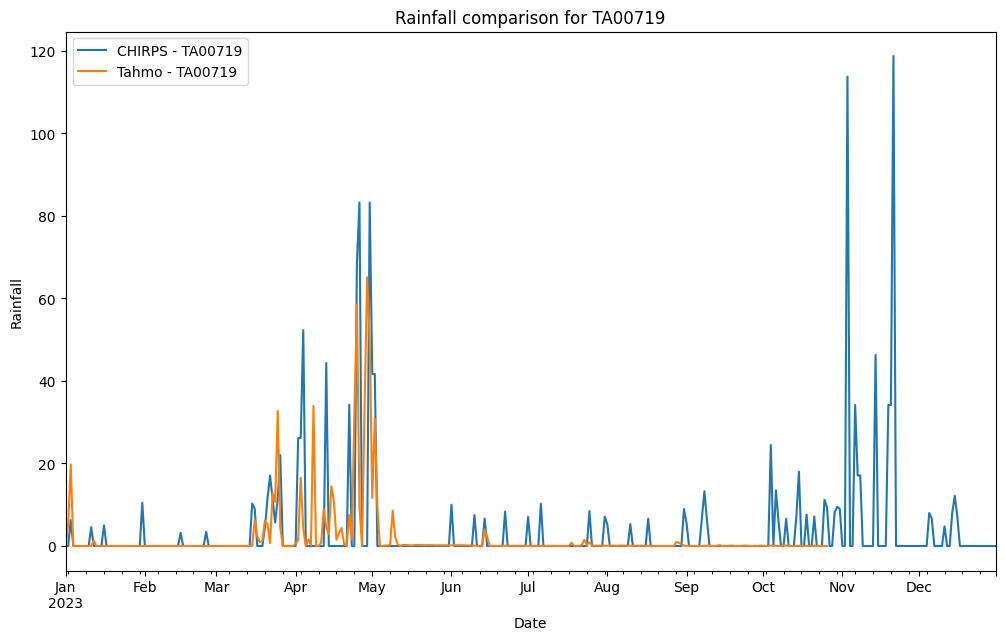

In [45]:
# plt.figure(figsize=(20,10))
for station_name in station_name_list:
  chirps_tahmo_ke[station_name].plot(figsize=(12,7), label=f'CHIRPS - {station_name}') # Added label
  # plt.legend(station_name)
  pr_df[station_name].plot(figsize=(12,7), label=f'Tahmo - {station_name}') # Added label
  # plt.legend(station_name)
  plt.legend() # Show the legend
  plt.xlabel("Date") # x axis label
  plt.ylabel("Rainfall") # y axis label
  plt.title(f"Rainfall comparison for {station_name}") # add title
  plt.show()

### ERA5

In [66]:
def create_monthly_chunks(start_date, end_date):
    """
    Create a list of monthly temporal chunks between start_date and end_date.

    Args:
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        list: A list of tuples, where each tuple contains the start and end date of a month.
    """
    # Convert start and end dates to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    # Initialize an empty list to store the chunks
    chunks = []

    # Generate chunks month by month
    current = start
    while current <= end:
        # Get the last day of the current month
        last_day_of_month = calendar.monthrange(current.year, current.month)[1]

        # Define the start and end date for the chunk
        chunk_start = current.strftime('%Y-%m-%d')
        chunk_end = datetime(current.year, current.month, last_day_of_month).strftime('%Y-%m-%d')

        # Ensure the chunk end does not exceed the global end date
        if datetime.strptime(chunk_end, '%Y-%m-%d') > end:
            chunk_end = end.strftime('%Y-%m-%d')

        # Append the chunk to the list
        chunks.append((chunk_start, chunk_end))

        # Move to the first day of the next month
        current = (current + timedelta(days=last_day_of_month)).replace(day=1)

    return chunks

# Example usage
start_date = '2023-01-01'
end_date = '2023-12-31'
temporal_chunks = create_monthly_chunks(start_date, end_date)
temporal_chunks


[('2023-01-01', '2023-01-31'),
 ('2023-02-01', '2023-02-28'),
 ('2023-03-01', '2023-03-31'),
 ('2023-04-01', '2023-04-30'),
 ('2023-05-01', '2023-05-31'),
 ('2023-06-01', '2023-06-30'),
 ('2023-07-01', '2023-07-31'),
 ('2023-08-01', '2023-08-31'),
 ('2023-09-01', '2023-09-30'),
 ('2023-10-01', '2023-10-31'),
 ('2023-11-01', '2023-11-30'),
 ('2023-12-01', '2023-12-31')]

In [102]:
# Define the region of interest
start_date = '2023-01-01'
end_date = '2023-12-31'

# Function to extract ERA5 data for a given point and time range
def extract_era5_hourly_series(lat, lon, start_date, end_date,
                               range_roi=[36.1, -0.3, 36.2, -0.2],
                               variable='total_precipitation'):
    # Add one day to the last day
    end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    roi = ee.Geometry.Rectangle(range_roi)   # coordinates in Kenya

    era5_hourly = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                .filterBounds(roi) \
                .select(variable)  # Precipitation band
    point = ee.Geometry.Point(lon, lat)

    # Filter the dataset by date range
    era5_hourly_chunk = era5_hourly.filterDate(start_date, end_date)

    def extract_rainfall(image):
        # Get date and time of the image
        date = image.get('system:time_start')
        # Extract precipitation value at the point
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('total_precipitation')
        return ee.Feature(None, {
            'datetime': ee.Date(date).format('YYYY-MM-dd HH:mm:ss'),
            'rainfall': value
        })

    # Apply extraction function to each image in the chunk
    rainfall_series = era5_hourly_chunk.map(extract_rainfall)
    features = rainfall_series.getInfo()['features']

    # Create a DataFrame from the features
    data = [{'Date': f['properties']['datetime'], 'Rainfall': f['properties']['rainfall']} for f in features]
    return pd.DataFrame(data)

# Temporal chunks for processing (one month per chunk)
temporal_chunks = create_monthly_chunks(start_date, end_date)

# Coordinates for the point of interest
lat, lon = -0.287122, 36.169981  # Example coordinates-0.287122	36.169981

# Initialize an empty DataFrame to store the results
era5_df = pd.DataFrame()

# Loop through each temporal chunk and append the results to the complete DataFrame
for start_date, end_date in temporal_chunks:
    print(f"Processing data from {start_date} to {end_date}...")
    chunk_df = extract_era5_hourly_series(lat, lon, start_date, end_date)
    era5_df = pd.concat([era5_df, chunk_df], ignore_index=True)

# Ensure 'Date' column is in datetime format
era5_df['Date'] = pd.to_datetime(era5_df['Date'])

era5_df

Processing data from 2023-01-01 to 2023-01-31...
Processing data from 2023-02-01 to 2023-02-28...
Processing data from 2023-03-01 to 2023-03-31...
Processing data from 2023-04-01 to 2023-04-30...
Processing data from 2023-05-01 to 2023-05-31...
Processing data from 2023-06-01 to 2023-06-30...
Processing data from 2023-07-01 to 2023-07-31...
Processing data from 2023-08-01 to 2023-08-31...
Processing data from 2023-09-01 to 2023-09-30...
Processing data from 2023-10-01 to 2023-10-31...
Processing data from 2023-11-01 to 2023-11-30...
Processing data from 2023-12-01 to 2023-12-31...


,Date,Rainfall
0,2023-01-01 00:00:00,1.734723e-18
1,2023-01-01 01:00:00,0.000000e+00
2,2023-01-01 02:00:00,3.469447e-18
3,2023-01-01 03:00:00,-3.469447e-18
4,2023-01-01 04:00:00,0.000000e+00
...,...,...
8755,2023-12-31 19:00:00,1.222038e-05
8756,2023-12-31 20:00:00,2.264594e-05
8757,2023-12-31 21:00:00,2.655718e-05
8758,2023-12-31 22:00:00,-1.734723e-18


In [93]:
era5_df.set_index('Date', inplace=True)
ret.aggregate_variables(era5_df, freq='1D', method='sum')

,Rainfall
Date,
2023-01-01,3.469447e-18
2023-01-02,5.905607e-05
2023-01-03,1.151413e-03
2023-01-04,2.091071e-04
2023-01-05,1.026452e-05
...,...
2023-12-27,3.092504e-06
2023-12-28,-1.040834e-17
2023-12-29,4.286697e-05


<Axes: xlabel='Date'>

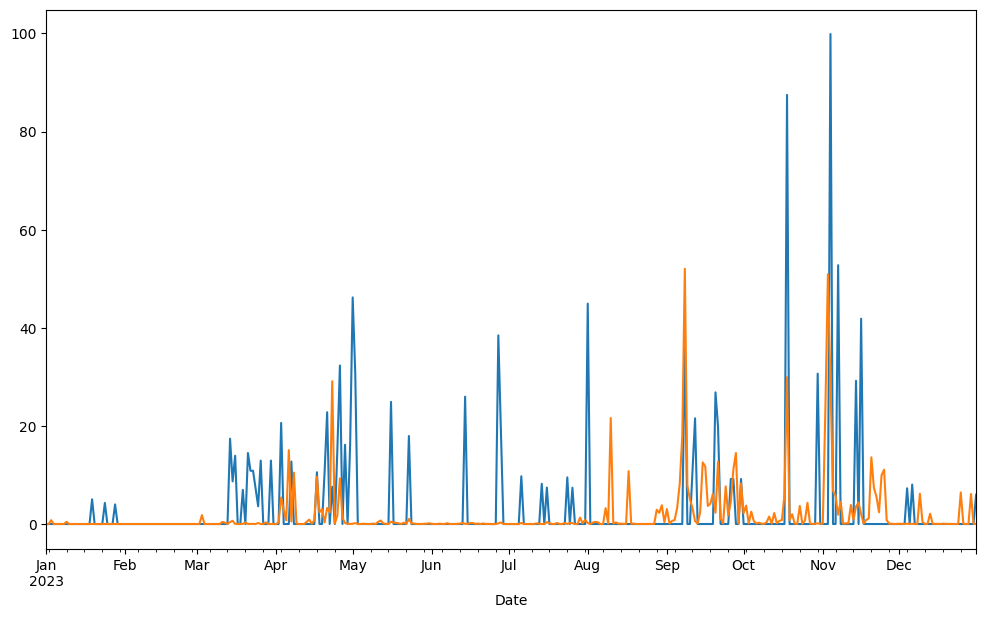

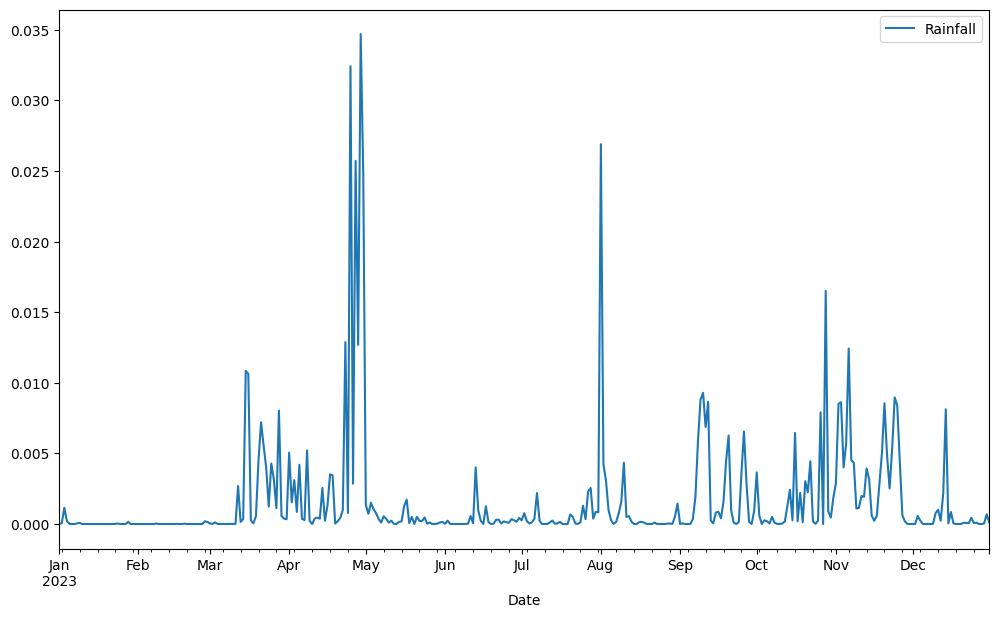

In [108]:
# rainfall_df.plot(x='Date', y='rainfall')
chirps_tahmo_ke[station_name_list[0]].plot(figsize=(12,7), label=f'CHIRPS - {station_name_list[0]}') # Added label
  # plt.legend(station_name)
pr_df[station_name_list[0]].plot(figsize=(12,7), label=f'Tahmo - {station_name_list[0]}') # Added label
ret.aggregate_variables(era5_df, freq='1D', method='sum').plot(figsize=(12,7), label=f'ERA5 - {station_name_list[0]}')


### CBAM

In [ ]:
# Replace with your API key
API_KEY = config['cbam_api_key']

# Example API endpoint for getting weather data
url = "https://api.tomorrow.io/v4/weather/forecast"

# Parameters for the request (adjust for CBAM-specific data)
params = {
    'location': '37.7749,-122.4194',  # Example coordinates (latitude, longitude)
    'units': 'metric',
    'timesteps': '1h',
    'apikey': API_KEY,
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process your CBAM data here
else:
    print(f"Error: {response.status_code}")


{'timelines': {'hourly': [{'time': '2025-01-22T05:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 2, 'dewPoint': 2.63, 'evapotranspiration': 0.104, 'freezingRainIntensity': 0, 'hailProbability': 52.7, 'hailSize': 4.97, 'humidity': 67, 'iceAccumulation': 0, 'iceAccumulationLwe': 0, 'precipitationProbability': 0, 'pressureSurfaceLevel': 1025.9, 'rainAccumulation': 0, 'rainAccumulationLwe': 0, 'rainIntensity': 0, 'sleetAccumulation': 0, 'sleetAccumulationLwe': 0, 'sleetIntensity': 0, 'snowAccumulation': 0, 'snowAccumulationLwe': 0, 'snowDepth': 0, 'snowIntensity': 0, 'temperature': 8.31, 'temperatureApparent': 8.31, 'uvHealthConcern': 0, 'uvIndex': 0, 'visibility': 16, 'weatherCode': 1000, 'windDirection': 313, 'windGust': 3.5, 'windSpeed': 2.88}}, {'time': '2025-01-22T06:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 1.74, 'dewPoint': 3.06, 'evapotranspiration': 0.085, 'freezingRainIntensity': 0, 'hailProbability': 7.9, 'hailSize': 6

In [ ]:
cbam_data.keys()

dict_keys(['timelines', 'location'])

In [ ]:
response.json()['location']

{'lat': 37.7749, 'lon': -122.4194}

In [ ]:
pd.json_normalize(response.json()['timelines']['hourly'])

,time,values.cloudBase,values.cloudCeiling,values.cloudCover,values.dewPoint,values.evapotranspiration,values.freezingRainIntensity,values.hailProbability,values.hailSize,values.humidity,...,values.snowIntensity,values.temperature,values.temperatureApparent,values.uvHealthConcern,values.uvIndex,values.visibility,values.weatherCode,values.windDirection,values.windGust,values.windSpeed
0,2025-01-22T05:00:00Z,NaN,NaN,2.00,2.63,0.104,0,52.7,4.97,67,...,0,8.31,8.31,0.0,0.0,16.00,1000,313.00,3.50,2.88
1,2025-01-22T06:00:00Z,NaN,NaN,1.74,3.06,0.085,0,7.9,6.80,65,...,0,9.48,9.48,0.0,0.0,16.00,1000,334.79,3.88,2.74
2,2025-01-22T07:00:00Z,NaN,NaN,0.00,3.15,0.074,0,27.1,5.91,67,...,0,9.05,9.05,0.0,0.0,16.00,1000,338.06,4.26,2.95
3,2025-01-22T08:00:00Z,NaN,NaN,0.00,3.38,0.063,0,90.1,0.61,69,...,0,8.97,8.97,0.0,0.0,16.00,1000,9.25,4.22,2.99
4,2025-01-22T09:00:00Z,NaN,NaN,0.00,3.12,0.053,0,14.2,7.31,70,...,0,8.46,8.46,0.0,0.0,16.00,1000,22.10,3.90,2.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2025-01-27T00:00:00Z,NaN,NaN,0.00,-0.95,0.098,0,37.2,5.29,40,...,0,12.47,12.47,NaN,NaN,24.13,1000,149.98,4.70,3.06
116,2025-01-27T01:00:00Z,NaN,NaN,0.00,0.28,0.078,0,93.5,2.36,45,...,0,12.09,12.09,NaN,NaN,24.13,1000,149.98,4.37,3.16
117,2025-01-27T02:00:00Z,NaN,NaN,0.00,1.52,0.057,0,55.5,9.24,50,...,0,11.71,11.71,NaN,NaN,24.13,1000,301.03,4.04,3.27
118,2025-01-27T03:00:00Z,NaN,NaN,0.00,2.75,0.037,0,71.0,9.50,56,...,0,11.33,11.33,NaN,NaN,24.14,1000,301.03,3.72,3.37


In [ ]:
import requests

# Replace with your actual API key
API_KEY = 'ah3J0edhmrvUGbozePmKzwv18yKvQgA9'

# Example API endpoint for historical weather data
url = "https://api.tomorrow.io/v4/timelines"

# Parameters for historical data request
params = {
    'location': '37.7749,-122.4194',  # Latitude, Longitude for the desired location
    'fields': ['temperature', 'windSpeed', 'humidity'],  # Replace with required CBAM fields
    'units': 'metric',  # Metric units for temperature, speed, etc.
    'timesteps': '1h',  # Time step resolution
    'startTime': '2024-01-01T00:00:00Z',  # Start date (in ISO 8601 format)
    'endTime': '2025-01-22T23:59:59Z',  # End date
    'timezone': 'UTC',  # Specify timezone if needed
    'apikey': API_KEY,  # API key
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process or save your historical CBAM data
else:
    print(f"Error: {response.status_code} - {response.text}")


Error: 403 - {"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}


In [ ]:
!curl --request GET \
  --url 'https://api.tomorrow.io/v4/timelines?location=37.7749,-122.4194&fields=temperature,precipitation&units=metric&timesteps=1h&startTime=2023-01-01T00:00:00Z&endTime=2023-12-31T23:59:59Z' \
  --header 'apikey: ah3J0edhmrvUGbozePmKzwv18yKvQgA9'


{"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}

### TAMSAT

In [ ]:
!git clone https://github.com/TAMSAT/tamsat_download_extraction_api

Cloning into 'tamsat_download_extraction_api'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 18), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 585.12 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ffeaa55b90226d7ea42bfb95545ac47835cc9fa631630f6319f25903dd304956
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
import sys
sys.path.append('/content/tamsat_download_extraction_api')

from tamsat_download_extract_api import download, extract


In [ ]:
download({
 "timestep": 'daily',
 "resolution": 0.25,
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Day.apply(lambda x: x in ["01", "02", "03", "04", "05"]), "Pentad"] = "1"
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DJF' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Month.ap

365 file(s) to download
 Downloaded file: rfe2023_01_01_0.25.v3.1.nc
 Downloaded file: rfe2023_01_02_0.25.v3.1.nc
 Downloaded file: rfe2023_01_03_0.25.v3.1.nc
 Downloaded file: rfe2023_01_04_0.25.v3.1.nc
 Downloaded file: rfe2023_01_05_0.25.v3.1.nc
 Downloaded file: rfe2023_01_06_0.25.v3.1.nc
 Downloaded file: rfe2023_01_07_0.25.v3.1.nc
 Downloaded file: rfe2023_01_08_0.25.v3.1.nc
 Downloaded file: rfe2023_01_09_0.25.v3.1.nc
 Downloaded file: rfe2023_01_10_0.25.v3.1.nc
 Downloaded file: rfe2023_01_11_0.25.v3.1.nc
 Downloaded file: rfe2023_01_12_0.25.v3.1.nc
 Downloaded file: rfe2023_01_13_0.25.v3.1.nc
 Downloaded file: rfe2023_01_14_0.25.v3.1.nc
 Downloaded file: rfe2023_01_15_0.25.v3.1.nc
 Downloaded file: rfe2023_01_16_0.25.v3.1.nc
 Downloaded file: rfe2023_01_17_0.25.v3.1.nc
 Downloaded file: rfe2023_01_18_0.25.v3.1.nc
 Downloaded file: rfe2023_01_19_0.25.v3.1.nc
 Downloaded file: rfe2023_01_20_0.25.v3.1.nc
 Downloaded file: rfe2023_01_21_0.25.v3.1.nc
 Downloaded file: rfe2023_01_22

In [ ]:
extract({
 "extract_type": 'point',
 "longitude": 36.169981,
 "latitude": -0.287122,
 "timestep": 'daily',
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

Extracting point TAMSAT rainfall estimates for longitude: 36.169981 and latitude: -0.287122


/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Day.apply(lambda x: x in ["01", "02", "03", "04", "05"]), "Pentad"] = "1"
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DJF' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Month.ap

Created file: /home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv


In [ ]:
tamsat_t26 = pd.read_csv('/home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv')
tamsat_t26.time = pd.to_datetime(tamsat_t26.time)
tamsat_t26.set_index('time', inplace=True)

In [ ]:
tamsat_t26

,rfe,rfe_filled,lon,lat
time,,,,
2023-01-01,0.0000,0.0000,36.125,-0.375
2023-01-02,0.0000,0.0000,36.125,-0.375
2023-01-03,0.0000,0.0000,36.125,-0.375
2023-01-04,0.0000,0.0000,36.125,-0.375
2023-01-05,0.0000,0.0000,36.125,-0.375
...,...,...,...,...
2023-12-27,0.0000,0.0000,36.125,-0.375
2023-12-28,0.0000,0.0000,36.125,-0.375
2023-12-29,4.2000,4.2000,36.125,-0.375


<Axes: xlabel='time'>

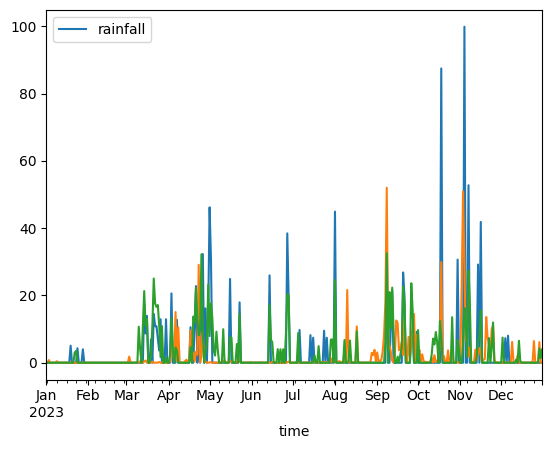

In [ ]:
rainfall_df.plot(x='Date', y='rainfall')
pr_df['TA00026'].plot()

tamsat_t26['rfe'].plot()

## Severe Weather Event Analysis
- Flash floods
- Heatwave

### EM-Data
Global Database for Comprehensive Disaster Data
Over 26,000 records of disasters from 1900 to the present day. <br>
- Data sourced from a diverse organizations: UN agencies, NGOs, insurance companies, research institutes, and press agencies.
- Available in open access for non-commercial use.
- Managed and distributed by the Centre for Research on the Epidemiology of Disasters (CRED) with the support of the United States Agency for International Development (USAID).

In [109]:
# upload em-data
uploaded = files.upload()

Saving public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx to public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx


In [110]:
# read the excel file
em_data = pd.read_excel('public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx')

In [111]:
em_data

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,2017-0032-MAR,No,nat-met-ext-col,Natural,Meteorological,Extreme temperature,Cold wave,GLIDE:CW-2017-000008,NaN,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,80.445779,"[{""adm1_code"":2109,""adm1_name"":""Oriental""},{""a...",2017-02-08,2023-09-25
1,2017-0033-DZA,No,nat-met-ext-col,Natural,Meteorological,Extreme temperature,Cold wave,GLIDE:CL-2017-000011,NaN,DZA,...,NaN,NaN,NaN,NaN,NaN,NaN,80.445779,"[{""adm1_code"":346,""adm1_name"":""Batna""},{""adm1_...",2017-02-08,2023-09-25
2,2017-0051-MOZ,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:FL-2017-000012,Cyclone 'Dineo',MOZ,...,NaN,NaN,NaN,NaN,17000.0,21132.0,80.445779,"[{""adm2_code"":21850,""adm2_name"":""Chibuto""},{""a...",2017-03-01,2024-04-09
3,2017-0054-MAR,No,nat-met-ext-col,Natural,Meteorological,Extreme temperature,Cold wave,GLIDE:CW-2016-000016,NaN,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,80.445779,"[{""adm2_code"":21818,""adm2_name"":""Figuig""},{""ad...",2017-03-01,2023-09-25
4,2017-0075-MDG,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Cyclone 'Enawo',MDG,...,NaN,NaN,NaN,NaN,20000.0,24861.0,80.445779,"[{""adm1_code"":41750,""adm1_name"":""Alaotra Mango...",2017-03-16,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2024-9131-ZMB,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,GLIDE:DR-2024-000018,NaN,ZMB,...,NaN,NaN,NaN,NaN,2261.0,NaN,NaN,NaN,2024-03-12,2025-01-16
529,2024-9197-MWI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,GLIDE:DR-2024-000066|GLIDE:DR-2024-000069,NaN,MWI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-05,2024-08-12
530,2024-9197-ZWE,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,GLIDE:DR-2024-000066|GLIDE:DR-2024-000069,NaN,ZWE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-05,2024-08-12
531,2024-9338-NAM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,GLIDE:DR-2024-000094,NaN,NAM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,2024-09-30


In [115]:
em_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [126]:
em_data[(em_data['Disaster Type'] == 'Flood') & (em_data['Country'] == 'Kenya') & (em_data['Start Year'] == 2023)][['Latitude', 'Longitude']]

,Latitude,Longitude
414,NaN,NaN
420,NaN,NaN
443,NaN,NaN


Extreme Rainfall Events:
2023-04-06 00:00:00+00:00    15.062
2023-04-08 00:00:00+00:00    10.472
2023-04-23 00:00:00+00:00    29.104
2023-08-10 00:00:00+00:00    21.602
2023-08-17 00:00:00+00:00    10.782
2023-09-07 00:00:00+00:00    17.995
2023-09-08 00:00:00+00:00    52.018
2023-09-15 00:00:00+00:00    12.559
2023-09-16 00:00:00+00:00    11.722
2023-09-21 00:00:00+00:00    12.723
2023-09-27 00:00:00+00:00    11.135
2023-09-28 00:00:00+00:00    14.474
2023-10-18 00:00:00+00:00    29.922
2023-11-02 00:00:00+00:00    23.245
2023-11-03 00:00:00+00:00    50.914
2023-11-04 00:00:00+00:00    28.824
2023-11-20 00:00:00+00:00    13.594
2023-11-24 00:00:00+00:00     9.953
2023-11-25 00:00:00+00:00    11.077
Name: TA00026, dtype: float64


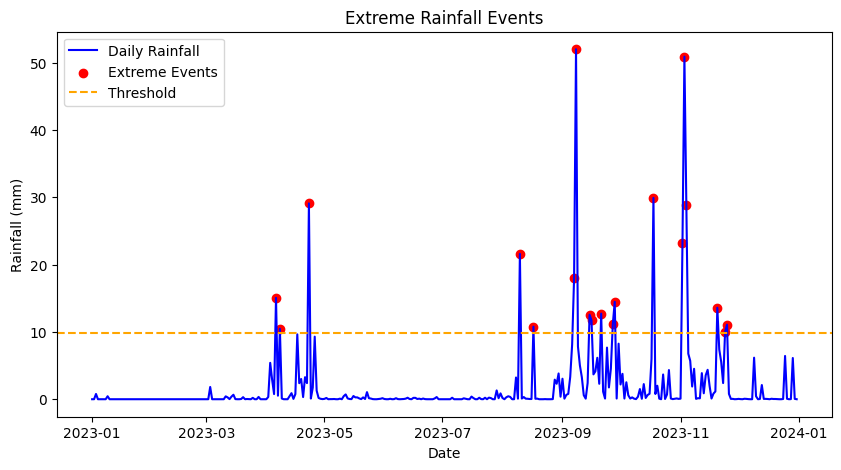

In [117]:
# Set threshold for extreme rainfall (e.g., 95th percentile)
threshold = pr_df[station_name_list[0]].quantile(0.95)

# Identify extreme events
extreme_rainfall_events = pr_df[station_name_list[0]][pr_df[station_name_list[0]]> threshold]
print("Extreme Rainfall Events:")
print(extreme_rainfall_events)

# Highlight extreme events in plot
plt.figure(figsize=(10, 5))
plt.plot(pr_df[station_name_list[0]].index, pr_df[station_name_list[0]], label='Daily Rainfall', color='blue')
plt.scatter(extreme_rainfall_events.index, extreme_rainfall_events, color='red', label='Extreme Events')
plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Extreme Rainfall Events')
plt.legend()
plt.show()
